In [3]:
# basic python data handling analysis modules
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
# small utility functions
from utility import *

# interactive jupyter widgets!
# https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    
    

In [ ]:
# The Movies Dataset
    # TMB_movies_metadata -> TMB_movies_metadata.csv
        # collections -> TMB_collections.csv
        # langs -> TMB_langs.csv
        # prod_companies -> TMB_prod_companies.csv
        # prod_countries -> TMB_prod_countries.csv

    # TMB_links
        # TMB_links_amalgamated -> TMB_links_amalgamated.csv

    # TMB_keywords -> TMB_keywords.csv (can be merged with TMB_movies_metadata)
    #    TMB_keys -> TMB_keys.csv

    # TMB_credits -> DONE it's job
    #    TMB_crew -> TMB_crew.csv
    #       TMB_crew_individuals -> TMB_crew_individuals.csv
    #    TMB_cast -> TMB_cast.csv
    #       TMB_cast_individuals -> TMB_crew_individuals.csv


# adult : bool -> int
# belongs_to_collection : int id -> collection df
    # collection
# budget, revenue: float (lot of fixes), budget, budget_normalised, revenue, revenue_normalised, revenue_divided_by_budget, revenue_divided_by_budget_normalised
# genres : dummied into bool genres_<Genres>, int num_genres_per_movie**
# homepage : left as string, int num_other_movies_with_same_homepage*
# id, imdb_id : dropped as already covered in TMB_links_amalgamated
# original_language : int points at lang df ids, num_langs_per_movie**
# spoken_languages: list of ints pointing at lang df ids
    # langs
# original_title, title: left as strings, bool original_title_differs_from_title, int title_used_by_num_other_movies**
# overview: left as string (some cleaning), int overview_length**
# popularity: float (0-550+), float popularity_normalised
# poster_path: string - jpgs, few pngs mostly consistent format left as is
# production_companies: strings -> converted to list int ids pointing at prod_companies df, int num_production_companies**
    # prod_companies
# production_countries : strings -> converted to list int id pointing at production_countries df, int num_production_countries**
    # prod_countries
# release_date : converted to datetime object, int release_year, int release_month, int release_day, str release_decade, int years_since_first_movie
#    (release_decade should be dummied)
# runtime : float, some "films" (>300mins) actually clearly tv so created tv_not_film (with exceptions for actually v long films)
# status: str categories (just 6), could dummy but almost all is in 'released', so just make dummy bool status_released
# tagline: str bit of cleaning otherwise left as is, int tagline_length, int num_other_movies_with_same_tagline
# video: bool, mostly false - not 100% clear what this is (no cinema release?)
# vote_count, vote_average: int/float, some cleaning (0 votes -> vote_average=0 -> np.nan), vote_average_normalised
#    (tried to normalise vote_count - complete failure!)

# movieId: int - one unique id I want for the dataset/to link to other datasets (also set as index, just conv to have as columns)


# ** (maybe don't normalised unless important?)    


In [5]:
TMB_files = ["TMB_movies_metadata","TMB_collections","TMB_langs","TMB_prod_companies","TMB_prod_countries",
"TMB_links_amalgamated","TMB_keywords","TMB_keys","TMB_crew","TMB_crew_individuals","TMB_cast","TMB_cast_individuals"]


# The Movies Dataset
    # TMB_movies_metadata -> TMB_movies_metadata.csv
        # collections -> TMB_collections.csv
        # langs -> TMB_langs.csv
        # prod_companies -> TMB_prod_companies.csv
        # prod_countries -> TMB_prod_countries.csv

    # TMB_links
        # TMB_links_amalgamated -> TMB_links_amalgamated.csv

    # TMB_keywords -> TMB_keywords.csv (can be merged with TMB_movies_metadata)
    #    TMB_keys -> TMB_keys.csv

    # TMB_credits -> DONE it's job -> ditched
    #    TMB_crew -> TMB_crew.csv (one row per credit)
    #       TMB_crew_individuals -> TMB_crew_individuals.csv
    #    TMB_cast -> TMB_cast.csv(one row per credit)
    #       TMB_cast_individuals -> TMB_cast_individuals.csv

In [214]:
Dataset_directory = ".."+os.sep+"Datasets"+os.sep

TMB_movies_metadata = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_movies_metadata"+".csv",index_col='movieId.1' )
TMB_movies_metadata.index = TMB_movies_metadata["movieId"]

TMB_collections = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_collections"+".csv",index_col="Unnamed: 0")
TMB_collections.index = TMB_collections["id"]

TMB_langs = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_langs"+".csv",index_col="Unnamed: 0")
TMB_langs.index = TMB_langs["id"]

TMB_prod_companies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_prod_companies"+".csv",index_col="id.1")
TMB_prod_companies.index = TMB_prod_companies["id"]

TMB_prod_countries = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_prod_countries"+".csv",index_col="iso_3166_1.1")
TMB_prod_countries.index = TMB_prod_countries["iso_3166_1"] # replace with numerical id??

TMB_links_amalgamated = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_links_amalgamated"+".csv",index_col="Unnamed: 0")
TMB_links_amalgamated.index = TMB_links_amalgamated["movieId"]

TMB_keywords = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_keywords"+".csv",index_col="Unnamed: 0")
TMB_keywords.index = TMB_keywords["movieId"]

TMB_keys = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_keys"+".csv",index_col="Unnamed: 0")
TMB_keys.index = TMB_keys["id"]

TMB_crew = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_crew"+".csv",index_col="Unnamed: 0")
TMB_crew.index = TMB_crew["credit_id"]

TMB_crew_individuals = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_crew_individuals"+".csv",index_col="Unnamed: 0")
TMB_crew_individuals.index = TMB_crew_individuals["id"]

TMB_cast = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_cast"+".csv",index_col="Unnamed: 0")
TMB_cast.index = TMB_cast["credit_id"]

TMB_cast_individuals = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_cast_individuals"+".csv",index_col="Unnamed: 0")
TMB_cast_individuals.index = TMB_cast_individuals["id"]
# gender 0=unknown, 1= female, 2= male

## data types tested!

In [215]:
TMB_keywords #-> merge with TMB_movies_metadata
TMB_movies_metadata["num_keywords"] = TMB_keywords["num_keywords"]
TMB_movies_metadata["keyword_id_list"] = TMB_keywords["keyword_id_list"]
del TMB_keywords

# TMB_crew -> crew size  - already covered because this is max_order!
# TMB_cast -> cast size  - already covered because this is max_order!

cast_size = TMB_cast.groupby("movieId").apply(lambda x: int(x["max_order"].mean()))
cast_list = TMB_cast.groupby("movieId").apply(lambda x: x["id"].values)

crew_size = TMB_crew.groupby("movieId").apply(lambda x: int(x["max_order"].mean()))
crew_list = TMB_crew.groupby("movieId").apply(lambda x: x["id"].values)

TMB_movies_metadata["cast_size"] = cast_size
TMB_movies_metadata["cast_list"] = cast_list

TMB_movies_metadata["crew_size"] = crew_size
TMB_movies_metadata["crew_list"] = crew_list
# remember, whole pile of movies with no cast/crew information!

cast_crew_intersection = intersection(TMB_crew["id"],TMB_cast["id"])
len(cast_crew_intersection)
# same id in cast/crew is the same individual!
# sadly, gender is the same in both sets (as in, when it's "0=unknown" in one, it's the same in the other)

14390

In [253]:
TMB_movies_metadata["collectionId"] = TMB_movies_metadata["belongs_to_collection"]
TMB_movies_metadata["belongs_to_collection"] = TMB_movies_metadata["belongs_to_collection"].notnull().astype('int')

In [242]:
TMB_movies_metadata.columns

Index(['movieId', 'adult', 'belongs_to_collection', 'budget', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count', 'movieId.1',
       'genres_Adventure', 'genres_Fantasy', 'genres_Animation',
       'genres_Drama', 'genres_Horror', 'genres_Action', 'genres_Comedy',
       'genres_History', 'genres_Western', 'genres_Thriller', 'genres_Crime',
       'genres_Documentary', 'genres_Science Fiction', 'genres_Mystery',
       'genres_Music', 'genres_Romance', 'genres_Family', 'genres_War',
       'genres_Foreign', 'genres_TV Movie', 'num_genres_per_movie',
       'num_langs_per_movie', 'original_title_differs_from_title',
       'title_used_by_num_other_movies', 'popularity_normalised',
       'num_production_companies', 'num_production_countries', 'rel

In [237]:
bools = (TMB_movies_metadata.dtypes=='bool')
bool_cols = bools[bools].index
TMB_movies_metadata[bool_cols] = TMB_movies_metadata[bool_cols].astype('int')

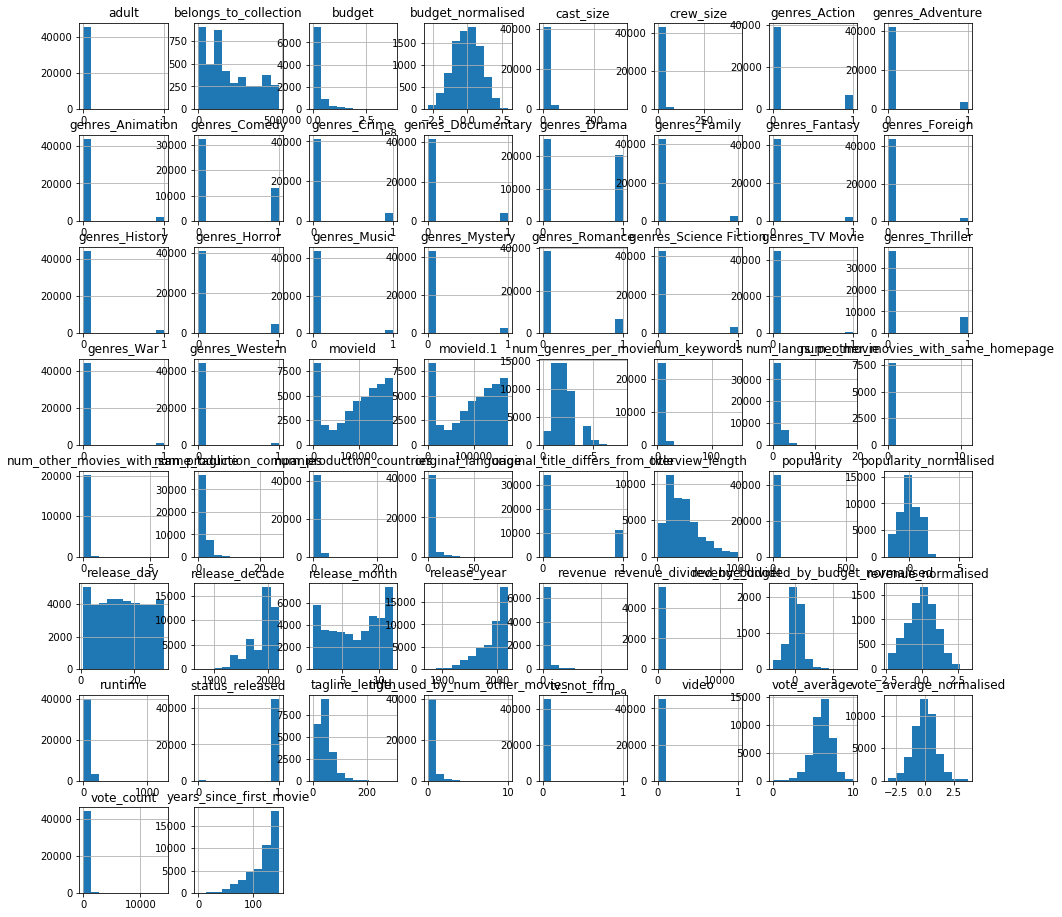

In [240]:
TMB_movies_metadata.hist(figsize =(16,16));
# belongs_to_collection -> could be renamed to be more clearly an id

In [ ]:
# TMB_langs -> need to get English language names!

In [273]:
# fix those 11 language nulls
TMB_movies_metadata.loc[TMB_movies_metadata["original_language"].isnull(),"original_language"] = 0
TMB_movies_metadata.loc[154832,"original_language"] = 18
TMB_movies_metadata.loc[172651,"original_language"] = 1
TMB_movies_metadata.loc[173819,"original_language"] = 4
TMB_movies_metadata.loc[173997,"original_language"] = 1
TMB_movies_metadata["original_language"] = TMB_movies_metadata["original_language"].astype('int')

In [276]:
original_language = TMB_movies_metadata["original_language"].copy()

language_dummy_number = 20

original_language_reduced = "language_"+original_language.apply(lambda x: TMB_langs.loc[x,"name"] if x<(language_dummy_number-1) else "Other")

original_language_reduced_dummied = pd.get_dummies(original_language_reduced)

TMB_movies_metadata[original_language_reduced_dummied.columns] = original_language_reduced_dummied

In [297]:
#### release decade --> dummy up!

In [300]:
objects = (TMB_movies_metadata.dtypes=='object') # lists, string - and one datetime object
object_cols = objects[objects].index
# TMB_movies_metadata[bool_cols] = TMB_movies_metadata[bool_cols].astype('int')
object_cols

Index(['homepage', 'original_title', 'overview', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'spoken_languages', 'status', 'tagline', 'title', 'keyword_id_list',
       'cast_list', 'crew_list'],
      dtype='object')

In [301]:
Id_columns = ["movieId","collectionId","original_language"]

In [303]:
unnormalised_columns = ["popularity","vote_average","budget","revenue","revenue_divided_by_budget"]

In [304]:
TMB_movies_numerical = TMB_movies_metadata.drop(object_cols,axis=1).drop(Id_columns,axis=1).drop(unnormalised_columns,axis=1).copy()

In [307]:
TMB_movies_numerical.describe()

,adult,belongs_to_collection,runtime,video,vote_count,genres_Adventure,genres_Fantasy,genres_Animation,genres_Drama,genres_Horror,...,language_Pусский,language_Türkçe,language_suomi,language_svenska,language_Český,language_हिन्दी,language_广州话 / 廣州話,language_日本語,language_普通话,language_한국어/조선말
count,45433.000000,45433.000000,43618.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,...,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000,45433.000000
mean,0.000198,0.098783,97.480352,0.002047,109.929545,0.076816,0.050822,0.042502,0.445579,0.102811,...,0.018181,0.003302,0.006493,0.008430,0.002883,0.011181,0.006889,0.029648,0.009002,0.009773
std,0.014073,0.298373,34.619451,0.045198,491.450762,0.266303,0.219637,0.201734,0.497035,0.303715,...,0.133606,0.057365,0.080318,0.091428,0.053620,0.105150,0.082716,0.169616,0.094453,0.098373
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,86.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,95.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,107.000000,0.000000,34.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1256.000000,1.000000,14075.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [310]:
TMB_movies_numerical.isnull().sum().sort_values().tail(20)

genres_TV Movie                             0
vote_count                                  0
genres_Action                               0
years_since_first_movie                    84
release_decade                             84
release_year                               84
crew_size                                 772
overview_length                          1114
runtime                                  1815
cast_size                                2415
vote_average_normalised                  2896
release_month                            3226
release_day                              3226
num_keywords                            19445
tagline_length                          25036
num_other_movies_with_same_tagline      25036
budget_normalised                       36553
num_other_movies_with_same_homepage     37659
revenue_normalised                      38035
revenue_divided_by_budget_normalised    40058
dtype: int64

7     8862
6     8514
4     8373
5     5076
3     3605
1     2809
8     2806
9     1847
0     1597
2      918
10     627
11     242
12      66
13      39
14      21
15      12
16      11
17       8
dtype: int64

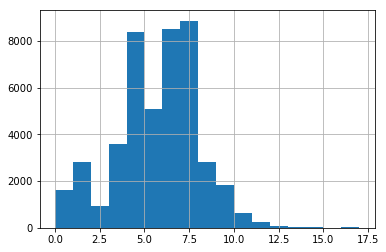

In [316]:
row_missingness = TMB_movies_numerical.isnull().sum(axis=1)
row_missingness.hist(bins=17)
row_missingness.value_counts()


In [315]:
TMB_movies_metadata[row_missingness>=17]

,movieId,adult,belongs_to_collection,budget,homepage,original_language,original_title,overview,popularity,poster_path,...,language_Pусский,language_Türkçe,language_suomi,language_svenska,language_Český,language_हिन्दी,language_广州话 / 廣州話,language_日本語,language_普通话,language_한국어/조선말
movieId,,,,,,,,,,,,,,,,,,,,,
90617,90617,0,0,NaN,NaN,16.0,Pajęczarki,NaN,0.000000,NaN,...,0,0,0,0,0,0,0,0,0,0
92747,92747,0,0,NaN,NaN,13.0,Pölynimurikauppiaat,NaN,0.000000,NaN,...,0,0,1,0,0,0,0,0,0,0
99596,99596,0,0,NaN,NaN,13.0,Aurinkotuuli,NaN,0.000127,NaN,...,0,0,1,0,0,0,0,0,0,0
154386,154386,0,0,NaN,NaN,14.0,Normaal: Ik Kom Altied Weer Terug,NaN,0.000000,/fFBqjfnwTu4O02xfMRbMQfJfCA7.jpg,...,0,0,0,0,0,0,0,0,0,0
163010,163010,0,0,NaN,NaN,0.0,Bad Dad Rehab,NaN,0.000253,/oUgQBEPLA8VAZtu5krty5zgKV1u.jpg,...,0,0,0,0,0,0,0,0,0,0
166289,166289,0,0,NaN,NaN,5.0,Allende en su laberinto,NaN,0.000000,/4qVpxyEtTZek9NZeasOIKdKOOve.jpg,...,0,0,0,0,0,0,0,0,0,0
167098,167098,0,0,NaN,NaN,4.0,Dolpo Tulku - Heimkehr in den Himalaya,NaN,0.000000,NaN,...,0,0,0,0,0,0,0,0,0,0
174953,174953,0,0,NaN,NaN,11.0,Mundo Cão,NaN,0.000331,NaN,...,0,0,0,0,0,0,0,0,0,0


In [323]:
TMB_movies_metadata_no_nan.columns

Index(['adult', 'belongs_to_collection', 'runtime', 'video', 'vote_count',
       'genres_Adventure', 'genres_Fantasy', 'genres_Animation',
       'genres_Drama', 'genres_Horror', 'genres_Action', 'genres_Comedy',
       'genres_History', 'genres_Western', 'genres_Thriller', 'genres_Crime',
       'genres_Documentary', 'genres_Science Fiction', 'genres_Mystery',
       'genres_Music', 'genres_Romance', 'genres_Family', 'genres_War',
       'genres_Foreign', 'genres_TV Movie', 'num_genres_per_movie',
       'num_langs_per_movie', 'original_title_differs_from_title',
       'title_used_by_num_other_movies', 'popularity_normalised',
       'num_production_companies', 'num_production_countries', 'release_year',
       'release_month', 'release_day', 'release_decade',
       'years_since_first_movie', 'tv_not_film',
       'num_other_movies_with_same_homepage', 'overview_length',
       'status_released', 'num_other_movies_with_same_tagline',
       'tagline_length', 'vote_average_normalise

In [319]:
TMB_movies_metadata_no_nan = TMB_movies_numerical.fillna(TMB_movies_numerical.mean()).copy()

In [322]:
TMB_movies_metadata_no_nan.to_stata(Dataset_directory+"Processed"+os.sep+ "TMB_movies_metadata_no_nan.dta")
# set up for doing Bayesian Belief Network fitting

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\pandas\io\stata.py:2136: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'genres_Science Fiction'   ->   genres_Science_Fiction
    b'genres_TV Movie'   ->   genres_TV_Movie
    b'original_title_differs_from_title'   ->   original_title_differs_from_titl
    b'num_other_movies_with_same_homepage'   ->   num_other_movies_with_same_homep
    b'num_other_movies_with_same_tagline'   ->   num_other_movies_with_same_tagli
    b'revenue_divided_by_budget_normalised'   ->   revenue_divided_by_budget_normal
    b'language_Espa\xc3\xb1ol'   ->   language_Espa_ol
    b'language_Fran\xc3\xa7ais'   ->   language_Fran_ais
    b'language_Portugu\xc3\xaas'   ->   language_Portugu_s
    b'language_P\xd1\x83\xd1\x81\xd1\x81\xd0\xba\xd0\xb8\xd0\xb9'   ->   language_P______
    b'language_T\xc3\xbcrk\xc3\xa7e'   ->   language_T_rk_e
    b'language_\xc

In [324]:
pattern = "revenue_divided_by_budget_normalised"
name = "revenue_divided_by_budget_normalised"
corr_type = "spearman"
df,corr_type = make_corr_summary(TMB_movies_numerical, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

## FIX display_corr not to overrun when limited pos/neg coe


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,r,p,N
revenue_normalised,0.6,0.00,5375
vote_count,0.4,0.00,5375
belongs_to_collection,0.31,0.00,5375
vote_average_normalised,0.3,0.00,5368
popularity_normalised,0.27,0.00,5375
num_keywords,0.2,0.00,4841
cast_size,0.18,0.00,5364
crew_size,0.14,0.00,5370
num_other_movies_with_same_homepage,0.11,0.00,1914
runtime,0.06,0.00,5363


In [325]:
pattern = "revenue_normalised"
name = "revenue_normalised"
corr_type = "spearman"
df,corr_type = make_corr_summary(TMB_movies_numerical, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

## FIX display_corr not to overrun when limited pos/neg coe


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,r,p,N
vote_count,0.72,0.00,7398
budget_normalised,0.71,0.00,5375
revenue_divided_by_budget_normalised,0.6,0.00,5375
popularity_normalised,0.59,0.00,7398
crew_size,0.43,0.00,7386
cast_size,0.41,0.00,7364
belongs_to_collection,0.31,0.00,7398
runtime,0.26,0.00,7371
num_production_companies,0.26,0.00,7398
genres_Adventure,0.25,0.00,7398


In [327]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



In [328]:
output_subfolder = ".."+os.sep+"Output"+os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [329]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(TMB_movies_metadata_no_nan.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = TMB_movies_metadata_no_nan.columns,
                             index   = TMB_movies_metadata_no_nan.index      )

In [330]:
%%time

n_components = BES_std.shape[1]
n_components = 10

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = TMB_movies_metadata_no_nan.index)

Wall time: 3min 55s


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\sklearn\decomposition\factor_analysis.py:237: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


In [334]:
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
#     if not os.path.exists(subdir): os.makedirs(subdir)
#     with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
# else: # LOAD decomp results (default is SAVE)
#     decomp_method = load_suff
#     subdir = output_subfolder + os.sep + decomp_method    
#     fname = subdir + os.sep + decomp_method
#     if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
#     # load decomp object, BES_decomp, BES_std, n_components
#     with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
#     BES_decomp = pd.read_hdf(fname+".hdf")
#     BES_std    = pd.read_hdf(fname+"_std"+".hdf")
#     n_components = decomp.components_.shape[0] 

average log-likelihood of all samples: -79.24099607423436
number of iterations: 1000


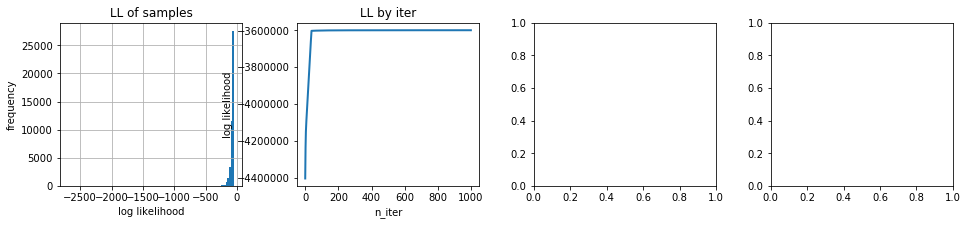

In [335]:
display_pca_data(n_components, decomp, BES_std)

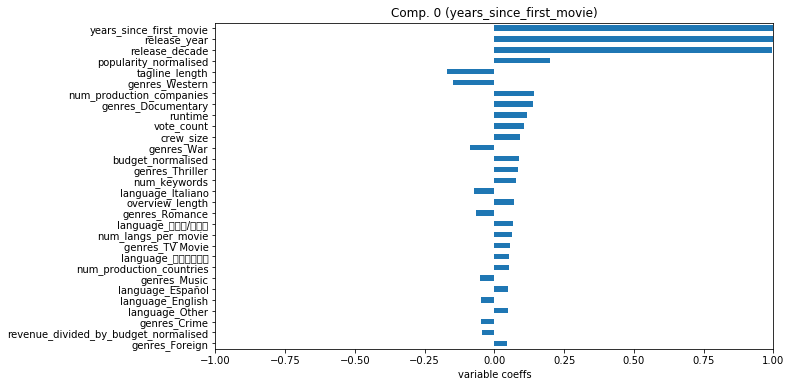

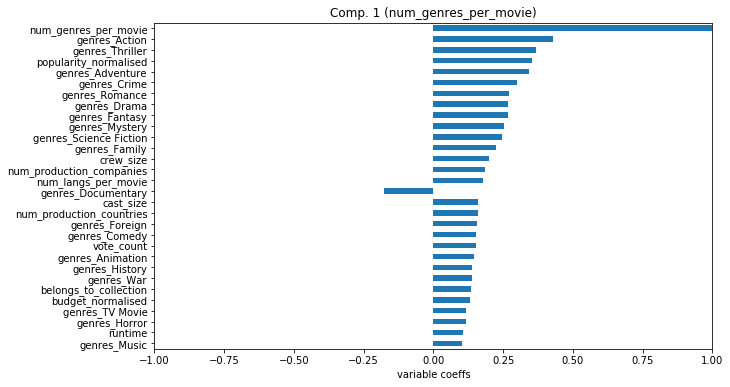

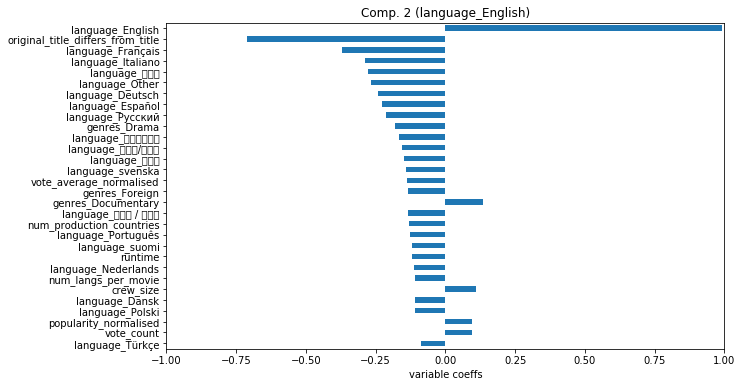

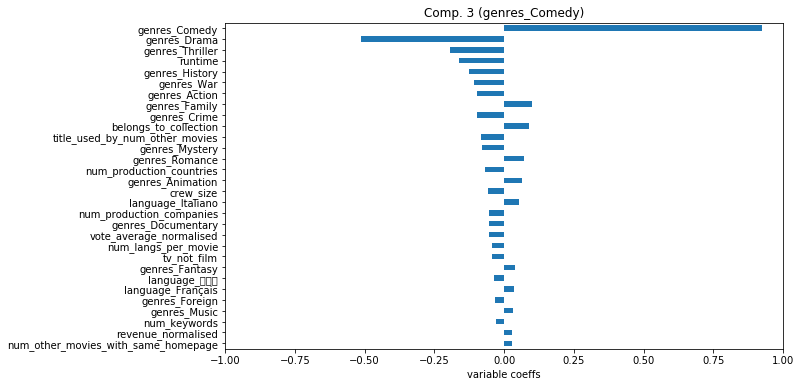

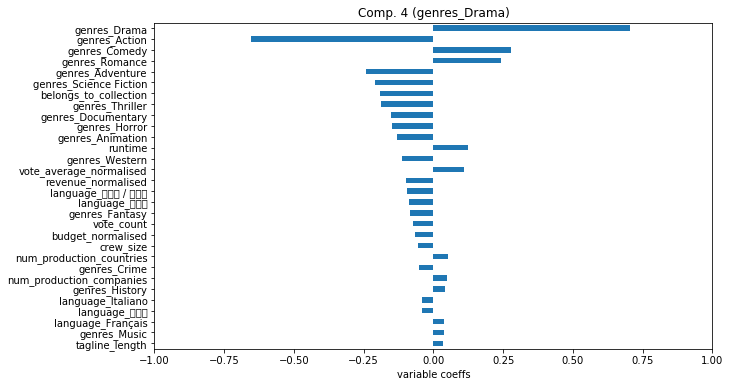

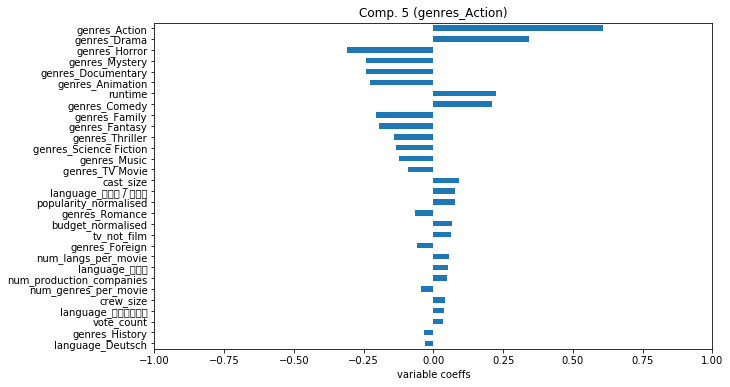

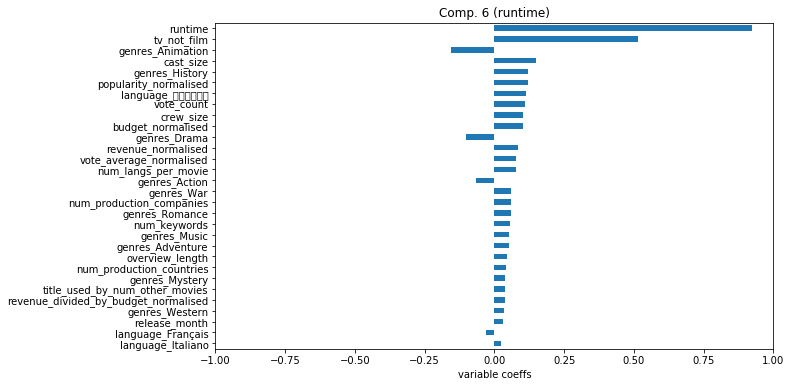

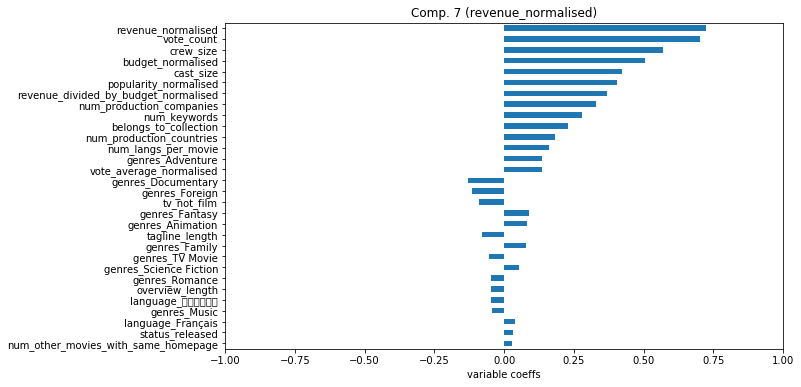

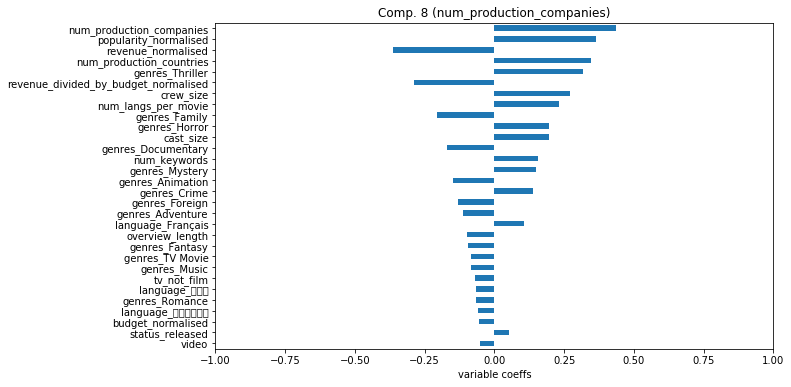

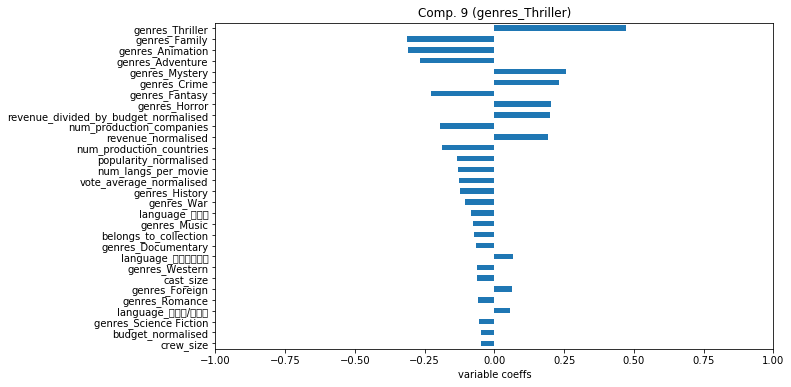

In [337]:


(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          TMB_movies_metadata_no_nan.columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 10, show_histogram = False)

In [333]:

def display_components(n_components, decomp, cols, BES_decomp, manifest, 
                       save_folder = False, show_first_x_comps=4,
                       show_histogram=True, flip_axes=True):
    
    if hasattr(decomp, 'coef_'):
        decomp_components = decomp.coef_
    elif hasattr(decomp, 'components_'):
        decomp_components = decomp.components_
    else:
        raise ValueError('no component attribute in decomp')    

    # hardcoded at 20?    
    n_comps = min(n_components,20)
    comp_labels = {}
    comp_dict = {}

    for comp_no in range(0,n_comps):

        fig, axes = plt.subplots(ncols=1+show_histogram)
        
        comp = pd.DataFrame( decomp_components[comp_no], index = cols, columns = ["components_"] )
        comp["comp_absmag"] = comp["components_"].abs()
        comp = comp.sort_values(by="comp_absmag",ascending=True)        
        
        if show_histogram:
            comp_ax = axes[0]
            
            hist_ax = axes[1]
            hist_ax.set_xlabel("abs. variable coeffs")
            hist_ax.set_title("Histogram of abs. variable coeffs")
            comp["comp_absmag"].hist( bins=30, ax=hist_ax, figsize=(10,6) )
            
        else:
            comp_ax = axes
            
        # set top abs_mag variable to label
        comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
        # if top abs_mag variable is negative
     
        if flip_axes & (comp[-1:]["components_"].values[0] < 0):

            comp["components_"]         = -comp["components_"]
            decomp_components[comp_no]  = -decomp_components[comp_no]
            BES_decomp[comp_no]         = -BES_decomp[comp_no]

        if manifest is not None:
            dataset_description = manifest["Friendlier_Description"].values[0]
            title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
            comp_labels[comp_no] = title
            comp_ax.set_title( dataset_description + "\n" + title )
            comp_ax.set_xlabel("variable coeffs")
            xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
            comp["components_"].tail(30).plot( kind='barh', ax=comp_ax, figsize=(10,6), xlim=xlim )
            dataset_citation = "Source: " + manifest["Citation"].values[0]

            if (save_folder != False):
                comp_ax.annotate(dataset_citation, (0,0), (0, -40),
                                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)            
                fname = save_folder + clean_filename(title) + ".png"
                fig.savefig( fname, bbox_inches='tight' )
        else:
            title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
            comp_labels[comp_no] = title
            comp_ax.set_title( title )
            comp_ax.set_xlabel("variable coeffs")    
            xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
            comp["components_"].tail(30).plot( kind='barh', ax=comp_ax, figsize=(10,6), xlim=xlim )
            
        comp_dict[comp_no] = comp
        # show first x components
        if (comp_no >= min(show_first_x_comps,n_components)):
            plt.close()

        
    return (BES_decomp, comp_labels, comp_dict)
    

def display_pca_data(n_components, decomp, BES_std, y=[]):    
    
    figsz = (16,3)
    
    f, axs = plt.subplots( 1, 4, figsize=figsz )

    axno = 0
    
    if hasattr(decomp, 'explained_variance_ratio_'):
        print('explained variance ratio (first 30): %s'
              % str(decomp.explained_variance_ratio_[0:30]) )
        
    if hasattr(decomp, 'explained_variance_'):
        print('explained variance (first 30): %s'
              % str(decomp.explained_variance_[0:30]) )

        axs[axno].plot( range(1,n_components+1), decomp.explained_variance_, linewidth=2)
        # ,figsize = figsz)
        axs[axno].set_xlabel('n_components')
        axs[axno].set_ylabel('explained_variance_')
        axs[axno].set_title('explained variance by n_components')
        axno = axno + 1
        
    if hasattr(decomp, 'noise_variance_'): 
        if isinstance(decomp.noise_variance_, float):
            print('noise variance: %s'
                  % str(decomp.noise_variance_) )
        
    if hasattr(decomp, 'score'):
        if len(y)==0:
            print('average log-likelihood of all samples: %s'
                  % str(decomp.score(BES_std)) )
        else:
            print('mean classification accuracy (harsh if many cats.): %s'
                  % str(decomp.score(BES_std, y)) )
        
    if hasattr(decomp, 'score_samples') and not np.isinf( decomp.score(BES_std) ):
        pd.DataFrame( decomp.score_samples(BES_std) ).hist(bins=100,figsize = figsz, ax=axs[axno])
        axs[axno].set_xlabel('log likelihood')
        axs[axno].set_ylabel('frequency')
        axs[axno].set_title('LL of samples')
        axno = axno + 1

    if hasattr(decomp, 'n_iter_'):
        print('number of iterations: %s'
              % str(decomp.n_iter_) )
        
    if hasattr(decomp, 'loglike_'):
        axs[axno].plot( decomp.loglike_, linewidth=2) # ,figsize = figsz)
        axs[axno].set_xlabel('n_iter')
        axs[axno].set_ylabel('log likelihood')
        axs[axno].set_title('LL by iter')
        axno = axno + 1

    if hasattr(decomp, 'error_'):

        axs[axno].plot( decomp.error_, linewidth=2, figsize = figsz)
        axs[axno].set_xlabel('n_iter')
        axs[axno].set_ylabel('error')
        axs[axno].set_title('LL by iter')
        axno = axno + 1
    